# Testing Analytics Zoo AutoML experimental features

## Overview
We are interested in air quality prediction and have been looking for AutoML functionality that is capable of doing  AutoML supported prediction using multivariant input data. As part of our "research" into this we "discovered" Analytics Zoo. This Notebook explains what we did to test it out (and yes, we managed to get it working).

Analytics Zoo is a unified data analytics and AI platform open sourced by Intel. It is basically a complete environment (including Jupyter Notebook server) for ML. It is put together by bits and pieces already out there and for the AutoML experimental setup they have also connected it to a scalable backend using Ray and Apache Spark. The following image gives an overview of the Analytics Zoo setup for AutoML using a scalable backend based on Tensorflow, Keras, Ray and Apache Spark. The AutoML part is a layer on top of the backend and the individual use cases are in a thin App layer, e.g. TimeSequencePredictor, which is an "App" for multivariant input/single variant output time series prediction on top of the underlaying architecture.

![Analytics Zoo on Ray](AnalyticZooAutoML-overview.png)

## Prepare a Conda environment 
For the testing I did set up an Ubuntu 18.04 virtual machine with 32 cores and 100GB RAM. When the VM was ready I did install Anaconda first:
```
# Download Anaconda
curl -O https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
#Install Anaconda
bash Anaconda3-2019.10-Linux-x86_64.sh
```
I then created an Anaconda environment and populated it with the needed packages:

```
# Create a Conda environment and activate it
conda create -n zoo python=3.6
conda activate zoo

# Installed all necessary packages with Conda
conda install tensorflow
conda install -c anaconda scikit-learn
conda install -c conda-forge featuretools
conda install pandas
conda install matplotlib
conda install requests
conda install aiohttp psutil setproctitle grpcio
conda install -c conda-forge tabulate
conda install -c conda-forge setproctitle
conda install jupyter
conda install -c anaconda openjdk=8.0.152

# Use pip to install the rest of the packages (that are not supported by conda)
pip install pyspark==2.4.3
pip install ray==0.6.6
```


## Get and compile the AnalyticsZoo AutoML package
To get the experimental AnalyticsZoo AutoML package we need to download and compile the source code for the AutoML branch. In order to do that we also need Maven:
```
sudo apt install maven
```

```
# Clone repo autoML branch
git clone --single-branch --branch automl https://github.com/intel-analytics/analytics-zoo.git

# Compile the AutoML branch (for linux) with Spark support (all the -D options)
bash analytics-zoo/pyzoo/dev/build.sh linux default -Dspark.version=2.4.3 -Dbigdl.artifactId=bigdl-SPARK_2.4 -P spark_2.4+

```
Install the newly compiled Analytics Zoo package (se above)
```
pip install analytics-zoo/pyzoo/dist/analytics_zoo-0.6.0.dev0-py2.py3-none-manylinux1_x86_64.whl
```

## Run the example
The example is based on this [article](https://medium.com/riselab/scalable-automl-for-time-series-prediction-using-ray-and-analytics-zoo-b79a6fd08139) (and the related Notebook) but uses air quality and Met.no data from Trondheim instead of taxi ride data from NYC.

In [1]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [2]:
# plot results of multi step forecasting
# plot at most five values for better view
# plot the predicted values and actual values (for the test data)
def plot_less_five_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(min(pred_df.shape[1] - 1, 5))]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
    plot_color = ["g", "r", "c", "m", "y"]
    for i in range(len(value_cols)):
        pred_value = pred_df[value_cols[i]].values
        pred_dt = pred_df[dt_col].values + time_delta * i
        axs.plot(pred_dt, pred_value, color=plot_color[i], label='predicted values' + str(i))

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# plot results of multi step forecasting
# plot result of multi step forecasting
# plot the predicted values and actual values (for the test data)
def plot_first_last_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(pred_df.shape[1] - 1)]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
  
    pred_value_first = pred_df[value_cols[0]].values
    pred_dt_first = pred_df[dt_col].values
    axs.plot(pred_dt_first, pred_value_first, color="g", label='first predicted values')
 
    pred_value_last = pred_df[value_cols[-1]].values
    pred_dt_last = pred_df[dt_col].values + time_delta * (len(value_cols)-1)
    axs.plot(pred_dt_last, pred_value_last, color="r", label='last predicted values')

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [5]:
# load airquality data
try:
    df = pd.read_csv('airquality_prepared.csv.xz', parse_dates=['fromTime'])
except Exception as e:
    print("airquality.csv.xz doesn't exist")

In [6]:
df.dtypes

fromTime                                         datetime64[ns, UTC]
NO0060A.PM10                                                 float64
NO0060A.PM2.5                                                float64
SN68860:0.air_temperature                                    float64
SN68860:0.relative_humidity                                  float64
SN68860:0.sum(duration_of_precipitation PT1H)                float64
SN68860:0.sum(precipitation_amount PT1H)                     float64
SN68860:0.surface_air_pressure                               float64
SN68860:0.wind_from_direction                                float64
SN68860:0.wind_speed                                         float64
dtype: object

In [7]:
df.head()

,fromTime,NO0060A.PM10,NO0060A.PM2.5,SN68860:0.air_temperature,SN68860:0.relative_humidity,SN68860:0.sum(duration_of_precipitation PT1H),SN68860:0.sum(precipitation_amount PT1H),SN68860:0.surface_air_pressure,SN68860:0.wind_from_direction,SN68860:0.wind_speed
0,2018-09-01 00:00:00+00:00,16.212345,6.610888,8.0,79.0,0.0,0.0,1006.0,150.0,1.0
1,2018-09-01 01:00:00+00:00,13.058908,4.298377,8.0,80.0,0.0,0.0,1006.0,153.0,0.0
2,2018-09-01 02:00:00+00:00,13.483383,3.751450,7.0,80.0,0.0,0.0,1006.0,30.0,0.0
3,2018-09-01 03:00:00+00:00,9.141075,2.598822,7.0,75.0,0.0,0.0,1006.0,149.0,1.0
4,2018-09-01 04:00:00+00:00,4.820948,0.048310,7.0,80.0,0.0,0.0,1006.0,92.0,0.0


In [8]:
df['fromTime'] = df['fromTime'].dt.tz_convert(None)

In [9]:
from zoo.automl.common.util import split_input_df
train_df, val_df, test_df = split_input_df(df, ts_col="fromTime", val_split_ratio=0.1, test_split_ratio=0.1)

Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.9.0-spark_2.4.3-0.6.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


In [10]:
train_df.describe()

,NO0060A.PM10,NO0060A.PM2.5,SN68860:0.air_temperature,SN68860:0.relative_humidity,SN68860:0.sum(duration_of_precipitation PT1H),SN68860:0.sum(precipitation_amount PT1H),SN68860:0.surface_air_pressure,SN68860:0.wind_from_direction,SN68860:0.wind_speed
count,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000
mean,12.443637,5.510887,5.541687,75.167115,23.751670,0.047311,994.725697,180.864378,2.103178
std,12.690607,6.284173,7.149469,15.939297,24.272789,0.288062,11.900986,86.069364,1.652280
min,-4.218054,-4.891530,-13.000000,20.000000,0.000000,0.000000,958.000000,0.000000,0.000000
25%,4.621233,2.016871,0.000000,64.000000,0.000000,0.000000,988.000000,123.000000,1.000000
50%,9.047965,4.059862,5.000000,79.000000,16.000000,0.000000,995.000000,200.000000,2.000000
75%,15.741199,6.714201,10.000000,88.000000,49.000000,0.000000,1002.000000,229.000000,3.000000
max,197.929553,72.163923,31.000000,99.000000,60.000000,7.000000,1026.000000,360.000000,12.000000


In [11]:
train_df.head(5)

,datetime,NO0060A.PM10,NO0060A.PM2.5,SN68860:0.air_temperature,SN68860:0.relative_humidity,SN68860:0.sum(duration_of_precipitation PT1H),SN68860:0.sum(precipitation_amount PT1H),SN68860:0.surface_air_pressure,SN68860:0.wind_from_direction,SN68860:0.wind_speed
0,2018-09-01 00:00:00,16.212345,6.610888,8.0,79.0,0.0,0.0,1006.0,150.0,1.0
1,2018-09-01 01:00:00,13.058908,4.298377,8.0,80.0,0.0,0.0,1006.0,153.0,0.0
2,2018-09-01 02:00:00,13.483383,3.751450,7.0,80.0,0.0,0.0,1006.0,30.0,0.0
3,2018-09-01 03:00:00,9.141075,2.598822,7.0,75.0,0.0,0.0,1006.0,149.0,1.0
4,2018-09-01 04:00:00,4.820948,0.048310,7.0,80.0,0.0,0.0,1006.0,92.0,0.0


In [12]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (8180, 10)
The shape of val_df is (1022, 10)
The shape of test_df is (1022, 10)


No handles with labels found to put in legend.


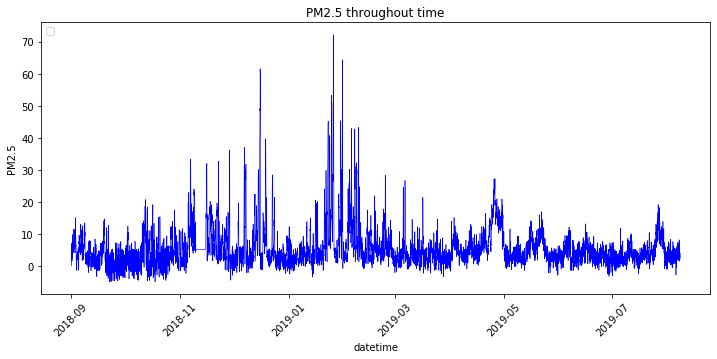

In [13]:
# visualisation of anomaly throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(train_df['datetime'], train_df['NO0060A.PM2.5'], color='blue', linewidth=0.6)
ax.set_title('PM2.5 throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('PM2.5')
plt.legend(loc='upper left')
plt.show()

In [14]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="NO0060A.PM2.5",
                            extra_features_col=["SN68860:0.air_temperature", "SN68860:0.relative_humidity", "SN68860:0.sum(duration_of_precipitation PT1H)", "SN68860:0.sum(precipitation_amount PT1H)", "SN68860:0.surface_air_pressure", "SN68860:0.wind_from_direction", "SN68860:0.wind_speed"])

In [15]:
from zoo.ray.util.raycontext import RayContext
from zoo import init_spark_on_local

sc = init_spark_on_local(cores=16)
ray_ctx = RayContext(sc=sc)

Current pyspark location is : /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
Successfully got a SparkContext
Start to launch the JVM guarding process
JVM guarding process has been successfully launched


In [16]:
ray_ctx.init()

Start to launch ray on cluster
Start to launch ray on local


In [17]:
%%time
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, GridRandomRecipe and BayesRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=RandomRecipe(look_back=(2, 4)))
print("Training completed.")

2020-02-28 12:29:05,451	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2020-02-28 12:29:05,453	INFO tune.py:211 -- Starting a new experiment.
2020-02-28 12:29:05,466	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 3.0/101.4 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/16 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 3.1/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - train_func_0_batch_size=64,dropout=0.42908,dropout_1=0.35836,dropout_2=0.31838,latent_dim=128,lr=0.0061468,lstm_1_units=16,lstm_2_units=64,model=LSTM,past_seq_len=4,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity']:	RUNNING

(pid=3920) Prepending /home/arneme/anaconda3/envs/zoo/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
(pid=3920) Prepending

(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4125 thread 9 bound to OS proc set 9
(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4120 thread 10 bound to OS proc set 10
(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4110 thread 11 bound to OS proc set 11
(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4129 thread 12 bound to OS proc set 12
(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4122 thread 13 bound to OS proc set 13
(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4139 thread 14 bound to OS proc set 14
(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4112 thread 15 bound to OS proc set 15
(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4116 thread 16 bound to OS proc set 16
(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4124 thread 17 bound to OS proc set 17
(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4109 thread 18 bound to OS proc set 18
(pid=3967) OMP: Info #251: KMP_AFFINITY: pid 3967 tid 4136 thread 19 bou

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 4.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 1 ({'TERMINATED': 1})
TERMINATED trials:
 - train_func_0_batch_size=64,dropout=0.42908,dropout_1=0.35836,dropout_2=0.31838,latent_dim=128,lr=0.0061468,lstm_1_units=16,lstm_2_units=64,model=LSTM,past_seq_len=4,selected_features=['IS_WEEKEND(datetime)' 'IS_AWAKE(datetime)'
 'SN68860:0.sum(precipitation_amount PT1H)' 'IS_WEEKEND(datetime)'
 'SN68860:0.relative_humidity' 'SN68860:0.relative_humidity'
 'SN68860:0.sum(precipitation_amount PT1H)' 'SN68860:0.relative_humidity']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=3967], 91 s, 10 iter

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 4.0/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 1 ({'TERMINATED': 1})
TERMINATE

In [18]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [19]:
pred_df.head(5)

,datetime,NO0060A.PM2.5
0,2019-09-19 14:00:00,3.168634
1,2019-09-19 15:00:00,2.407849
2,2019-09-19 16:00:00,4.879859
3,2019-09-19 17:00:00,2.829086
4,2019-09-19 18:00:00,3.018967


In [20]:
# prediction value start from 50
test_df[50:55]

,datetime,NO0060A.PM10,NO0060A.PM2.5,SN68860:0.air_temperature,SN68860:0.relative_humidity,SN68860:0.sum(duration_of_precipitation PT1H),SN68860:0.sum(precipitation_amount PT1H),SN68860:0.surface_air_pressure,SN68860:0.wind_from_direction,SN68860:0.wind_speed
50,2019-09-21 12:00:00,11.277157,5.913731,12.0,77.0,60.0,0.0,1001.0,252.0,5.0
51,2019-09-21 13:00:00,12.045061,5.979859,12.0,76.0,59.0,0.0,1001.0,240.0,4.0
52,2019-09-21 14:00:00,12.784105,6.090603,12.0,76.0,60.0,0.0,1001.0,242.0,3.0
53,2019-09-21 15:00:00,12.131678,5.602268,13.0,73.0,23.0,0.0,1001.0,253.0,3.0
54,2019-09-21 16:00:00,12.850315,6.393126,13.0,72.0,53.0,0.0,1000.0,245.0,3.0


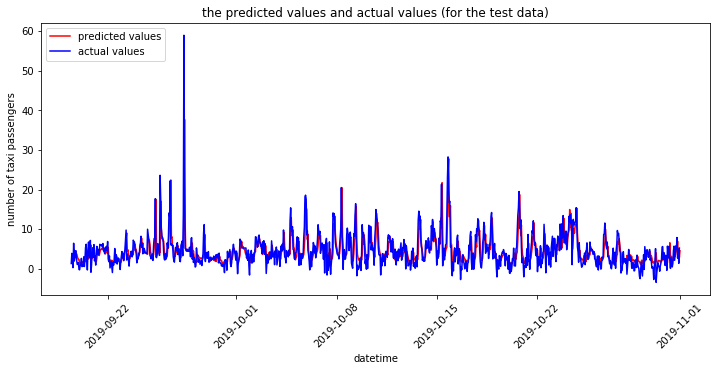

In [21]:
# plot the predicted values and actual values
plot_result(test_df, pred_df, value_col="NO0060A.PM2.5")

In [22]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 10.592701887685367
Evaluate: the smape value is 28.22726969073179


## Save and restore


In [23]:
# save the pipeline with best trial
pipeline.save("/tmp/saved_pipeline/my.ppl")

Pipeline is saved in /tmp/saved_pipeline/my.ppl


'/tmp/saved_pipeline/my.ppl'

In [24]:
from zoo.automl.pipeline.time_sequence import load_ts_pipeline
new_pipeline = load_ts_pipeline("/tmp/saved_pipeline/my.ppl")

LSTM is selected.
Restore pipeline from /tmp/saved_pipeline/my.ppl


In [25]:
# you can do predict and evaluate again
# we use test_df as input in order to compare results before and after restoration 
new_pred = new_pipeline.predict(test_df)

In [26]:
new_pred.head(5)

,datetime,NO0060A.PM2.5
0,2019-09-19 14:00:00,3.168634
1,2019-09-19 15:00:00,2.407849
2,2019-09-19 16:00:00,4.879859
3,2019-09-19 17:00:00,2.829086
4,2019-09-19 18:00:00,3.018967


In [27]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 10.592701887685367
Evaluate: the smape value is 28.22726969073179


## Continue training

In [28]:
# review the initialization infomation if needed
new_pipeline.describe()

**** Initialization info ****
future_seq_len: 1
dt_col: datetime
target_col: NO0060A.PM2.5
extra_features_col: ['SN68860:0.air_temperature', 'SN68860:0.relative_humidity', 'SN68860:0.sum(duration_of_precipitation PT1H)', 'SN68860:0.sum(precipitation_amount PT1H)', 'SN68860:0.surface_air_pressure', 'SN68860:0.wind_from_direction', 'SN68860:0.wind_speed']
drop_missing: True



In [29]:
# Use val_df as incremental data
new_pipeline.fit(val_df,epoch_num=5)

Train on 1018 samples
Epoch 1/5
1018/1018 [==============================] - 7s 7ms/sample - loss: 0.1065 - mean_squared_error: 0.1065
Epoch 2/5
1018/1018 [==============================] - 2s 2ms/sample - loss: 0.1082 - mean_squared_error: 0.1082
Epoch 3/5
1018/1018 [==============================] - 1s 972us/sample - loss: 0.1095 - mean_squared_error: 0.1095
Epoch 4/5
1018/1018 [==============================] - 1s 1ms/sample - loss: 0.1052 - mean_squared_error: 0.1052
Epoch 5/5
1018/1018 [==============================] - 1s 1ms/sample - loss: 0.1082 - mean_squared_error: 0.1082
Fit done!


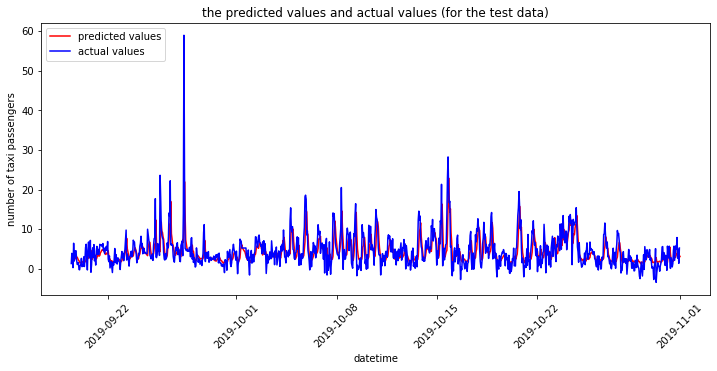

In [33]:
# predict results of test_df
new_pred_df = new_pipeline.predict(test_df)
plot_result(test_df, new_pred_df, value_col="NO0060A.PM2.5")

In [34]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 11.09516299680221
Evaluate: the smape value is 28.84956439340656


## Multi step forecasting

In [36]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# change future_seq_len into the step you want to forcast.
tsp = TimeSequencePredictor(future_seq_len=5,
                            dt_col="datetime",
                            target_col="NO0060A.PM2.5",
                            extra_features_col=None)

In [37]:
%%time
# you can specify the look back sequence length with a single number or a range of (min_len, max_len) in RandomRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=RandomRecipe(look_back=10))
print("Training completed.")

2020-02-28 12:40:17,813	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2020-02-28 12:40:17,814	INFO tune.py:211 -- Starting a new experiment.
2020-02-28 12:40:17,826	WARNING logger.py:220 -- Could not instantiate <class 'ray.tune.logger.TFLogger'> - skipping.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 3.9/101.4 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/16 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 3.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - train_func_0_batch_size=1024,dropout=0.3928,dropout_1=0.23037,dropout_2=0.3235,latent_dim=256,lr=0.0015731,lstm_1_units=32,lstm_2_units=8,model=Seq2seq,selected_features=['IS_WEEKEND(datetime)' 'IS_WEEKEND(datetime)' 'HOUR(datetime)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)']:	RUNNING

(pid=3969) 2020-02-28 12:40:19,235	WARNING worker.py:201 -- Calling ray.get or ray.wait in a separate thread may lead to deadlock if the main thread blocks on this thread and there are not enough resources to execute more tasks
(pid=3969) 2020-02-28 12:40:20.070125: I tensorflow/core/platform/cpu_

(pid=3969) OMP: Info #251: KMP_AFFINITY: pid 3969 tid 5399 thread 28 bound to OS proc set 28
(pid=3969) OMP: Info #251: KMP_AFFINITY: pid 3969 tid 5404 thread 29 bound to OS proc set 29
(pid=3969) OMP: Info #251: KMP_AFFINITY: pid 3969 tid 5411 thread 30 bound to OS proc set 30
(pid=3969) OMP: Info #251: KMP_AFFINITY: pid 3969 tid 5400 thread 31 bound to OS proc set 31
(pid=3969) OMP: Info #251: KMP_AFFINITY: pid 3969 tid 5397 thread 32 bound to OS proc set 0
== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/16 CPUs, 0/0 GPUs (0/1.0 ps, 0/1.0 trainer)
Memory usage on this node: 4.9/101.4 GB
Result logdir: /home/arneme/ray_results/automl
Number of trials: 1 ({'RUNNING': 1})
RUNNING trials:
 - train_func_0_batch_size=1024,dropout=0.3928,dropout_1=0.23037,dropout_2=0.3235,latent_dim=256,lr=0.0015731,lstm_1_units=32,lstm_2_units=8,model=Seq2seq,selected_features=['IS_WEEKEND(datetime)' 'IS_WEEKEND(datetime)' 'HOUR(datetime)'
 'IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)'

In [38]:
# test
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [39]:
pred_df.head(5)

,datetime,NO0060A.PM2.5_0,NO0060A.PM2.5_1,NO0060A.PM2.5_2,NO0060A.PM2.5_3,NO0060A.PM2.5_4
0,2019-09-19 20:00:00,4.256179,3.897661,3.304503,2.787576,2.441719
1,2019-09-19 21:00:00,3.693086,3.302458,2.790653,2.394291,2.169887
2,2019-09-19 22:00:00,3.176681,2.859693,2.482340,2.210221,2.082606
3,2019-09-19 23:00:00,2.796745,2.556683,2.290756,2.110868,2.047748
4,2019-09-20 00:00:00,2.615418,2.441495,2.255037,2.130839,2.098428


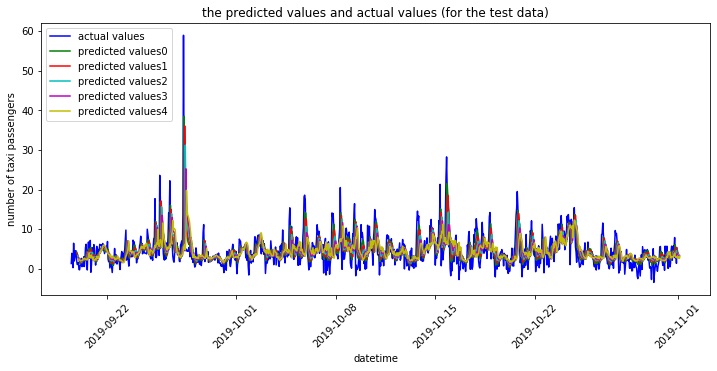

In [40]:
# plot multi step predicted values and actual values
# plot at most five step predict values for better view
plot_less_five_step_result(test_df, pred_df, value_col="NO0060A.PM2.5")

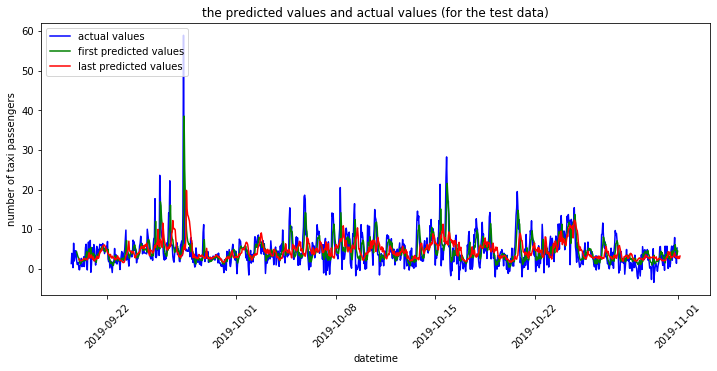

In [41]:
# plot only the first and the last step predict values and actual values
plot_first_last_step_result(test_df, pred_df, value_col="NO0060A.PM2.5")

In [42]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is [11.88359202 15.97963478 17.42568706 17.90445343 18.05786756]
Evaluate: the smape value is [28.84813446 30.93325527 31.84521042 32.44531807 32.61204477]


In [43]:
ray_ctx.stop()

Stopping pgids: [3888, 3950]
Stopping by pgid 3888
Stopping by pgid 3950
